# Multi-armed bandits with OpenAI

In [42]:
import gym
import gym_bandits   # see https://github.com/JKCooper2/gym-bandits

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

Note: OpenAI doesn't have a multi-armed bandit environment so I'm using this one from https://github.com/JKCooper2/gym-bandits. 

So we end up with these Bandits:

In [2]:
print(f"we've got {len(gym.envs.registry.all())} environments, with the Bandit ones being:")
[env for env in list(gym.envs.registry.all()) if "bandit" in str(env).lower()]

we've got 805 environments, with the Bandit ones being:


[EnvSpec(BanditTenArmedRandomFixed-v0),
 EnvSpec(BanditTenArmedRandomRandom-v0),
 EnvSpec(BanditTenArmedGaussian-v0),
 EnvSpec(BanditTenArmedUniformDistributedReward-v0),
 EnvSpec(BanditTwoArmedDeterministicFixed-v0),
 EnvSpec(BanditTwoArmedHighHighFixed-v0),
 EnvSpec(BanditTwoArmedHighLowFixed-v0),
 EnvSpec(BanditTwoArmedLowLowFixed-v0)]

## OpenAI gym basics

Making an env like so:

In [3]:
env = gym.make('BanditTenArmedGaussian-v0')

WARN: Environment '<class 'gym_bandits.bandit.BanditTenArmedGaussian'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


See the action space, which for our ten armed bandits is just a number from 0 to 9, representing each bandit - the action is just passing in which bandit to use, and the observation_space is just a number `0` - for in this simple game a game is just one play, so there is no observation per se, just a reward, which could be any number, though in practice with a real bandit it would have a upper bound:

In [4]:
env.action_space, env.observation_space, env.reward_range

(Discrete(10), Discrete(1), (-inf, inf))

the gym has a built in method `env.action_space.sample` to randomly sample from the action space. So for the 10 bandits are actions look like:

In [5]:
[env.action_space.sample() for _ in range(15)]

[5, 0, 3, 3, 7, 9, 3, 5, 2, 4, 7, 6, 8, 8, 1]

lets take a look at the probability distribution for the bandits:

In [9]:
env.unwrapped.p_dist

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

the 1's in the probablity distrubution `p_dist` tells us that each bandit will always pay out. If the p_dist had numbers less than one, like 0.5, then we would have a 50% probablity of a payout. So lets take a look at the actual payouts - the reward distribution `r_dist` tells us the mean and the std dev of the payment of each bandit:

In [8]:
actual_rewards = env.unwrapped.r_dist
actual_rewards

[[0.7628161654577119, 1],
 [0.3160977245132496, 1],
 [-1.1250449656588166, 1],
 [1.7746462255584685, 1],
 [-0.6349177546013717, 1],
 [-0.9636746610897318, 1],
 [-0.778100957636072, 1],
 [2.1184172163730732, 1],
 [0.2900750605388444, 1],
 [-0.9139533292718035, 1]]

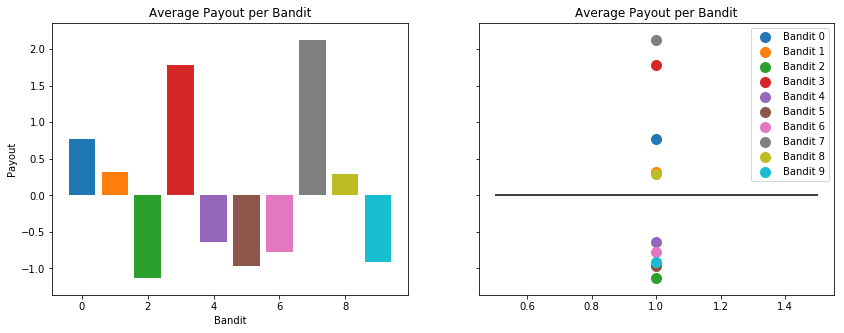

In [127]:
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

axes[0].set_title("Average Payout per Bandit")
axes[0].set_xlabel("Bandit")
axes[0].set_ylabel("Payout")
for i, r in enumerate([r for r,_ in actual_rewards]):
    axes[0].bar(i, r, label=f"Bandit {i}")

axes[1].set_title("Average Payout per Bandit")
for i, r in enumerate([r for r,_ in actual_rewards]):
    axes[1].scatter(1, r, label=f"Bandit {i}", s=100)
axes[1].hlines(0, 0.5,1.5)
axes[1].legend();

## The basics of an openai env are:

- **observations** - an object giving the state of the environment, like position of pieces on a board, velocities, camera data, etc
- **reward** - a float number the reward after an action, generally higher the better, with +ve being good and -ve being bad
- **done** - many environments have an end state, so this tells us if we're finished (agent died, game ended, etc)
- **info** - diagnostic info

So lets take a look at our multi-armed bandits:

In [7]:
observation = env.reset()

for i_episode in range(3):
  
    print("episode Number is", i_episode)   
    action = env.action_space.sample() # sampling the "action" array which in this case only contains 10 "options" because there is 10 bandits
    print("action is", action)
        
    # here we taking the next "step" in our environment by taking in our action variable randomly selected above
    observation, reward, done, info = env.step(action) 
        
    print("observation space is: ",observation)
    print("reward variable is: ",reward)
    print("done flag is: ",done)
    print("info variable is: ",info)
    print("--"*20)
            
env.close()

episode Number is 0
action is 6
observation space is:  0
reward variable is:  -1.219889651437949
done flag is:  True
info variable is:  {}
----------------------------------------
episode Number is 1
action is 7
observation space is:  0
reward variable is:  1.3200084553910885
done flag is:  True
info variable is:  {}
----------------------------------------
episode Number is 2
action is 7
observation space is:  0
reward variable is:  2.2779578822808193
done flag is:  True
info variable is:  {}
----------------------------------------
